# HW03 - ChBE 413
**Name:** Mikkel Flores  
**Due Date:** September 18, 2025

# Question 1: A Molecule is a Bag of Elements!

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import combinations

**Part a**

In [74]:
df = pd.read_csv("Tm_200_subset_original.csv")
print(df.shape)
df.head()

(201, 5)


,smiles,Tm,num_atms,dipole,quadrupole
0,CC1=C(C=CC(O)=N1)[N+]([O-])=O,508.15,17,4.473978,23.191697
1,COC1=C(N)C=C(C=C1)C(=O)N(C)C,393.15,28,4.772571,21.767880
2,CC1=CC=C(Cl)C(N)=C1,303.95,17,2.216088,7.920099
3,BrC1(C(=O)C2=CC=CC=C2C1=O)C1=CC=CC=C1,379.15,27,3.919235,21.700726
4,NC1=C(Cl)C=C(Cl)C=C1I,353.15,14,2.157331,4.988358


In [75]:
def smiles_to_bag(smiles: str) -> np.ndarray:
    search_elements = ["Cl", "Br", "C", "O", "N", "B", "I", "F", "S", "P"]
    bag_vector = np.zeros(len(search_elements), dtype=int)
    
    for i, element in enumerate(search_elements):
        count = smiles.count(element)
        bag_vector[i] += count
        smiles = smiles.replace(element, "")
    return bag_vector    

In [76]:
# Test
print(smiles_to_bag("CCCCC"))
print(smiles_to_bag("ClCBr"))

[0 0 5 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]


In [77]:
df["bag_vector"] = df["smiles"].apply(smiles_to_bag)
df[["smiles", "bag_vector"]].head()

,smiles,bag_vector
0,CC1=C(C=CC(O)=N1)[N+]([O-])=O,"[0, 0, 6, 3, 2, 0, 0, 0, 0, 0]"
1,COC1=C(N)C=C(C=C1)C(=O)N(C)C,"[0, 0, 10, 2, 2, 0, 0, 0, 0, 0]"
2,CC1=CC=C(Cl)C(N)=C1,"[1, 0, 7, 0, 1, 0, 0, 0, 0, 0]"
3,BrC1(C(=O)C2=CC=CC=C2C1=O)C1=CC=CC=C1,"[0, 1, 15, 2, 0, 0, 0, 0, 0, 0]"
4,NC1=C(Cl)C=C(Cl)C=C1I,"[2, 0, 6, 0, 1, 0, 1, 0, 0, 0]"


**Part b**

With no normalization

In [78]:
def dot_similarity(vec1, vec2):
    return np.dot(vec1, vec2)

In [79]:
# Test
v1 = smiles_to_bag("CCCCC")
v2 = smiles_to_bag("CCC")
v3 = smiles_to_bag("ClCBr")

print(dot_similarity(v1, v2))  # Expect 15 (5*3)
print(dot_similarity(v1, v3))  # Expect 5 (5*1)

15
5


In [80]:
pairs = []
for i, j in combinations(range(len(df)), 2):
    similarity = dot_similarity(df.loc[i, "bag_vector"], df.loc[j, "bag_vector"])
    pairs.append((i, j, similarity))

pairs_df = pd.DataFrame(pairs, columns=["mol1_index", "mol2_index", "similarity"])
pairs_df.head()

,mol1_index,mol2_index,similarity
0,0,1,70
1,0,2,44
2,0,3,96
3,0,4,38
4,0,5,76


In [81]:
print("Most similar:\n", pairs_df.nlargest(3, "similarity"))
print("\nLeast similar:\n", pairs_df.nsmallest(3, "similarity"))

Most similar:
        mol1_index  mol2_index  similarity
5450           29          86         714
13584          86         126         714
13624          86         166         710

Least similar:
       mol1_index  mol2_index  similarity
9619          55         160           4
5076          27          55           5
6259          34          55           5


With normalization

In [82]:
def dot_similarity_normalized(vec1, vec2):
    denominator = (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    if denominator == 0:
        return 0
    return np.dot(vec1, vec2) / denominator    

In [83]:
print(dot_similarity_normalized(v1, v2))  # Expect 1
print(dot_similarity_normalized(v1, v3))  # Expect < 1

1.0
0.5773502691896258


In [84]:
pairs_norm = []
for i, j in combinations(range(len(df)), 2):
    similarity = dot_similarity_normalized(df.loc[i, "bag_vector"], df.loc[j, "bag_vector"])
    pairs_norm.append((i, j, similarity))

pairs_norm_df = pd.DataFrame(pairs_norm, columns=["mol1_index", "mol2_index", "similarity"])
pairs_norm_df.head()

,mol1_index,mol2_index,similarity
0,0,1,0.962250
1,0,2,0.880176
2,0,3,0.904293
3,0,4,0.837647
4,0,5,0.991117


In [85]:
print("Most similar:\n", pairs_norm_df.nlargest(3, "similarity"))
print("\nLeast similar:\n", pairs_norm_df.nsmallest(3, "similarity"))

Most similar:
       mol1_index  mol2_index  similarity
370            1         172         1.0
1819           9          65         1.0
1878           9         124         1.0

Least similar:
       mol1_index  mol2_index  similarity
9541          55          82    0.495074
9596          55         137    0.521247
9619          55         160    0.525226


The unnormalized dot product measures the raw overlap in element counts. For this reason some bias is introduced because molecules with more atoms overall get higher scores because there are more chances for overlap. Therefore, the similarities seen doesn't necessarily equate to chemical similarity.

The normalized dot product measures the composition similarity based on element ratios within each molecule. It removes the bias introduced by the unnormalized dot product since element proportion matters more than molecule size. These similarity scores are bound between 0 and 1, with a score of 1 representing identical element compositions even if they are different sizes. Because I believe the normalized dot product to be a more representative metric, I will continue with part b using the normalized similarity scores.

In [86]:
from IPython.display import display, SVG

def plot_molecule_pair(idx1, idx2, similarity, title=""):
    mol1 = Chem.MolFromSmiles(df.loc[idx1, "smiles"])
    mol2 = Chem.MolFromSmiles(df.loc[idx2, "smiles"])
    img = Draw.MolsToGridImage(
        [mol1, mol2], 
        molsPerRow=2, 
        subImgSize=(300, 300), 
        legends=[f"Mol {idx1} (sim={similarity:.2f})", f"Mol {idx2} (sim={similarity:.2f})"], 
        useSVG=True
        )
    display(SVG(img))
    print(title, ":", df.loc[idx1, "smiles"], "|", df.loc[idx2, "smiles"])
  

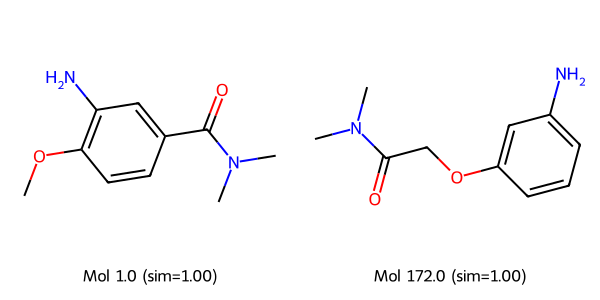

Most similar : COC1=C(N)C=C(C=C1)C(=O)N(C)C | CN(C)C(=O)COC1=CC(N)=CC=C1


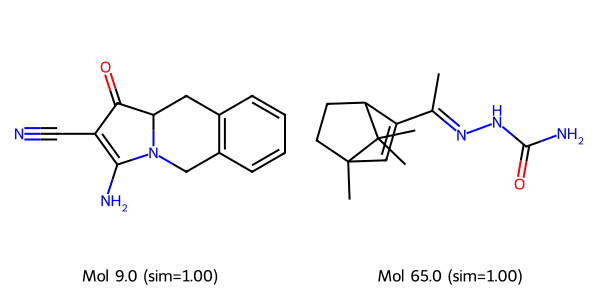

Most similar : NC1=C(C#N)C(=O)C2CC3=C(CN12)C=CC=C3 | CC(=NNC(N)=O)C1=CC2(C)CCC1C2(C)C


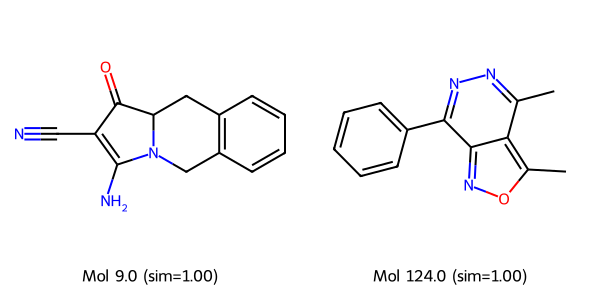

Most similar : NC1=C(C#N)C(=O)C2CC3=C(CN12)C=CC=C3 | CC1=C2C(=NO1)C(=NN=C2C)C1=CC=CC=C1


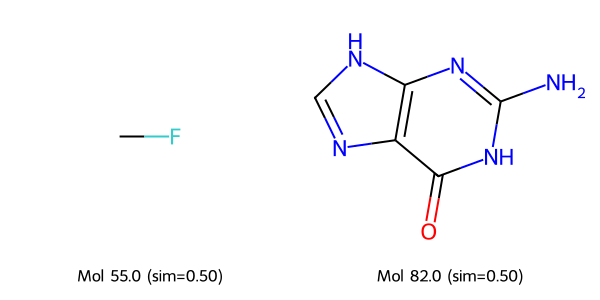

Least similar : CF | NC1=NC2=C(N=CN2)C(=O)N1


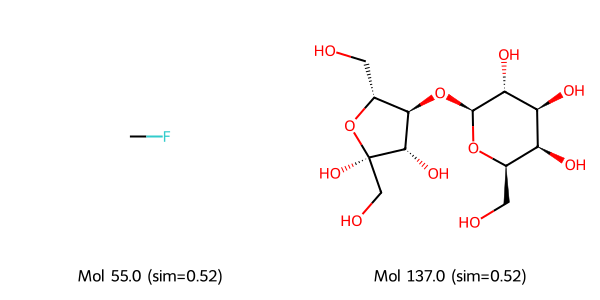

Least similar : CF | OC[C@H]1O[C@](O)(CO)[C@@H](O)[C@@H]1O[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@H]1O


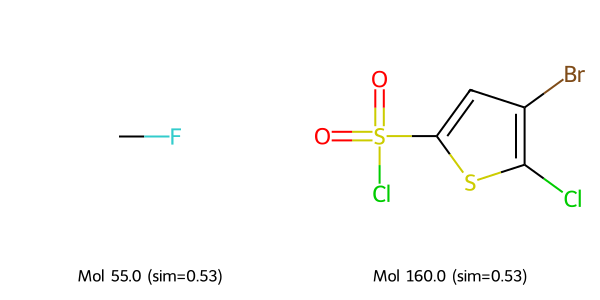

Least similar : CF | ClC1=C(Br)C=C(S1)S(Cl)(=O)=O


In [87]:
most_similar = pairs_norm_df.nlargest(3, "similarity")
for i, row in most_similar.iterrows():
    plot_molecule_pair(row.mol1_index, row.mol2_index, row.similarity, "Most similar")

least_similar = pairs_norm_df.nsmallest(3, "similarity")
for i, row in least_similar.iterrows():
    plot_molecule_pair(row.mol1_index, row.mol2_index, row.similarity, "Least similar")

Along with the points I made above about using the dot product, the normalized dot product does remove the size bias, but it only reflects the similarity in elemental ratios. Molecules with identical atom counts can appear quite similar even if the bonding and functional groups are completely different. On the other hand, molecules with overlapping substructures may show as very dissimilar even if they share meaningful chemistry. 

Going off of that, the Bag-of-Elements approach does not consider isomers (e.g. ethanol vs dimethyl ether). The placement of functional groups, the steoreochemistry, conjugation, and molecular shape are all features not recognized by this approach.

**Part c**

In [88]:
def l2_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

In [89]:
pairs_l2 = []
for i, j in combinations(range(len(df)), 2):
    distance = l2_distance(df.loc[i, "bag_vector"], df.loc[j, "bag_vector"])
    pairs_l2.append((i, j, distance))

pairs_l2_df = pd.DataFrame(pairs_l2, columns=["mol1_index", "mol2_index", "distance"])
pairs_l2_df.head()

,mol1_index,mol2_index,distance
0,0,1,4.123106
1,0,2,3.464102
2,0,3,9.327379
3,0,4,3.872983
4,0,5,4.123106


In [90]:
most_similar_l2 = pairs_l2_df.nsmallest(3, "distance")
least_similar_l2 = pairs_l2_df.nlargest(3, "distance")

print("Most similar (L2 distance):\n", most_similar_l2)
print("\nLeast similar (L2 distance):\n", least_similar_l2)

Most similar (L2 distance):
       mol1_index  mol2_index  distance
370            1         172       0.0
1819           9          65       0.0
1878           9         124       0.0

Least similar (L2 distance):
       mol1_index  mol2_index   distance
9585          55         126  26.419690
9545          55          86  26.400758
5419          29          55  25.199206


In [91]:
def plot_molecule_pair_l2(idx1, idx2, distance, title=""):
    mol1 = Chem.MolFromSmiles(df.loc[idx1, "smiles"])
    mol2 = Chem.MolFromSmiles(df.loc[idx2, "smiles"])
    img = Draw.MolsToGridImage(
        [mol1, mol2], 
        molsPerRow=2, 
        subImgSize=(300, 300), 
        legends=[f"Mol {idx1} (dist={distance:.2f})", f"Mol {idx2} (dist={distance:.2f})"], 
        useSVG=True
        )
    display(SVG(img))
    print(title, ":", df.loc[idx1, "smiles"], "|", df.loc[idx2, "smiles"])

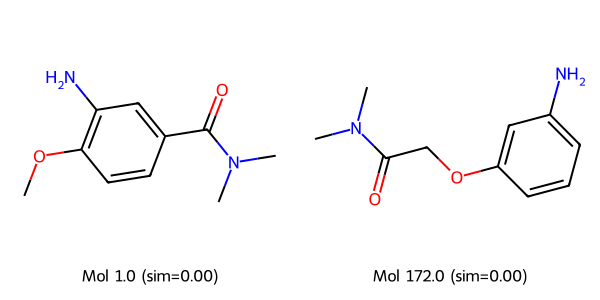

Most similar (L2) : COC1=C(N)C=C(C=C1)C(=O)N(C)C | CN(C)C(=O)COC1=CC(N)=CC=C1


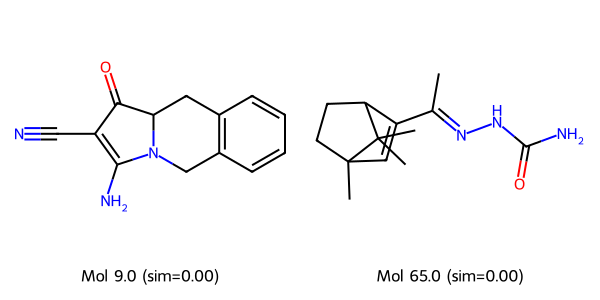

Most similar (L2) : NC1=C(C#N)C(=O)C2CC3=C(CN12)C=CC=C3 | CC(=NNC(N)=O)C1=CC2(C)CCC1C2(C)C


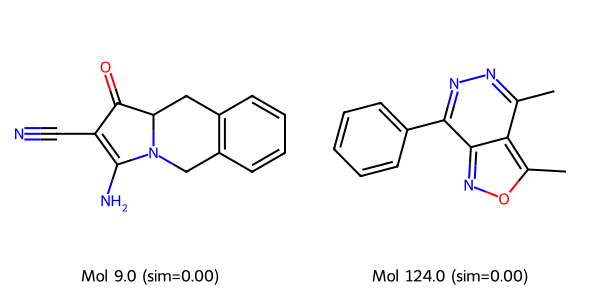

Most similar (L2) : NC1=C(C#N)C(=O)C2CC3=C(CN12)C=CC=C3 | CC1=C2C(=NO1)C(=NN=C2C)C1=CC=CC=C1


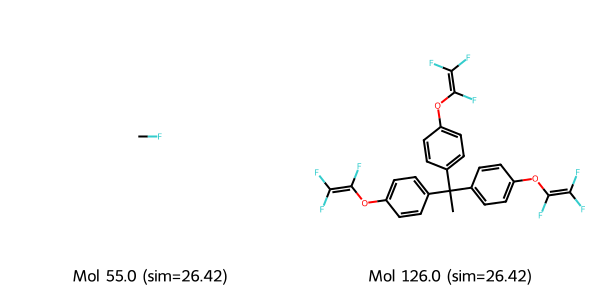

Least similar (L2) : CF | CC(C1=CC=C(OC(F)=C(F)F)C=C1)(C1=CC=C(OC(F)=C(F)F)C=C1)C1=CC=C(OC(F)=C(F)F)C=C1


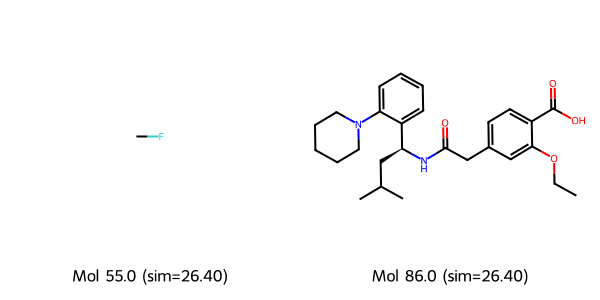

Least similar (L2) : CF | CCOC1=CC(CC(=O)N[C@@H](CC(C)C)C2=CC=CC=C2N2CCCCC2)=CC=C1C(O)=O


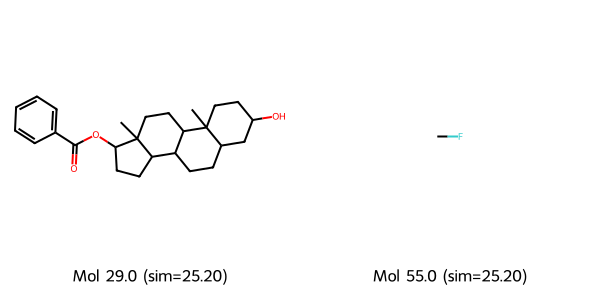

Least similar (L2) : CC12CCC3C(CCC4CC(O)CCC34C)C1CCC2OC(=O)C1=CC=CC=C1 | CF


In [92]:
for i, row in most_similar_l2.iterrows():
    plot_molecule_pair(row.mol1_index, row.mol2_index, row.distance, "Most similar (L2)")

for i, row in least_similar_l2.iterrows():
    plot_molecule_pair(row.mol1_index, row.mol2_index, row.distance, "Least similar (L2)")


The L2 distance metric measures the absoulte difference in atom counts between the two molecules. In this case, distance 0 means the molecules have the same Bag-of-Elements vector. Larger distances indicate more differences in elemental compositions. By changing the concept of distance, it seems that the L2 measure has differences from the normalized dot product in only the 3 least similar section. The L2 norm compares those very small molecules to the very large ones and gets different results because the differences in absolute atom count still dominates over the difference in elemental ratios.

# Question 2: Linear Regression for Melting Points

**Part a**

In [93]:
train_df = df.iloc[:160]
test_df = df.iloc[160:]

train_stats = train_df[["Tm", "num_atms", "dipole", "quadrupole"]].agg(["mean", "std"])
test_stats = test_df[["Tm", "num_atms", "dipole", "quadrupole"]].agg(["mean", "std"])

print("Training set statistics:\n", train_stats)
print("\nTest set statistics:\n", test_stats)


Training set statistics:
               Tm   num_atms    dipole  quadrupole
mean  404.873750  26.775000  3.868060   16.650092
std    79.961733  10.376528  2.055919   10.091921

Test set statistics:
               Tm   num_atms    dipole  quadrupole
mean  405.720244  28.439024  3.502150   19.625662
std    73.497793   9.607416  1.948123   14.397216


The test set appears to be reasonably representative of the training set. The means and standard deviations of Tm, num_atms, dipole, and quadrupole are similar between the two sets. This suggests that the test set can be used as a fair benchmark for evaluating model performance without introducing strong bias. Notably, the mean and std of the quadrupole seems to have the most variation between the test and training sets.


**Part b**

In [95]:
features = ["num_atms", "dipole", "quadrupole"]
results = []

for feature in features:
    X_train = train_df[[feature]]
    y_train = train_df["Tm"]
    X_test = test_df[[feature]]
    y_test = test_df["Tm"]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results.append({
        "feature": feature,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse
    })

results_df = pd.DataFrame(results)
results_df

,feature,train_r2,test_r2,train_rmse,test_rmse
0,num_atms,0.011540,0.033354,79.250195,71.374981
1,dipole,0.162898,-0.200288,72.930649,79.534414
2,quadrupole,0.126509,0.127287,74.498914,67.818474


Out of the three models, it seems that quadrupole most strongly correlates with Tm. While dipole has the highest R2 in its training set, it does not generalize well to new data as seen by the negative R2 in its test set. Quadrupole has the best balance with its slightly lower R2 train and highest R2 test. Additionally, it has the second lowest train rmse and the lowest test rmse, leading me to conclude that quadrupole moment has the strongest correlation with Tm.

The num_atoms model appears to be equally weak on both its test and training sets. The dipole model performs well on the training sets, but poorly on the test sets, meaning it overfits on the training data and fails to generalize to new data. The quadrupole moment has test performance that is slightly better than its training sets, meaning it is the best model at generalizing to unseen data.

**Part c**

In [96]:
X = np.vstack(df["bag_vector"].values)
y = df["Tm"].values

X_train = X[:160]
y_train = y[:160]
X_test = X[160:]
y_test = y[160:]

model_boe = LinearRegression()
model_boe.fit(X_train, y_train)

y_train_pred_boe = model_boe.predict(X_train)
y_test_pred_boe = model_boe.predict(X_test)

train_r2_boe = r2_score(y_train, y_train_pred_boe)
test_r2_boe = r2_score(y_test, y_test_pred_boe)
train_rmse_boe = np.sqrt(mean_squared_error(y_train, y_train_pred_boe))
test_rmse_boe = np.sqrt(mean_squared_error(y_test, y_test_pred_boe))

print(f"Bag-of-Elements model results:")
print(f"Train R2: {train_r2_boe:.4f}, Test R2: {test_r2_boe:.4f}")
print(f"Train RMSE: {train_rmse_boe:.4f}, Test RMSE: {test_rmse_boe:.4f}")

Bag-of-Elements model results:
Train R2: 0.2977, Test R2: 0.1927
Train RMSE: 66.8020, Test RMSE: 65.2265
